# CenterResnet Starter


I am very new to these concepts so I am trying out by changing this amazing and probably only 3D model related awesome public kernel by Ruslan
https://www.kaggle.com/hocop1/centernet-baseline

Most of the codes are loaned from there . There are other codes that I took from OFT implementation github . But I dont know what is OFT , so I have not yet implemented it . 

My current score is not from this kernel( as there are some errors in this kernel) , but from some simple architecture modification of the original public kernel. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = '../input/pku-autonomous-driving/'
os.listdir(PATH)

## Constants
SWITCH_LOSS_EPOCH = 4

train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

IMG_WIDTH = 2048
IMG_HEIGHT = IMG_WIDTH // 4
MODEL_SCALE = 8

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        for k in ['x', 'pitch', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict


def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img, flip=False):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 6]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    if flip:
        img = img[:,::-1]
    return (img / 255).astype('float32')


def get_mask_and_regr(img, labels, flip=False):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 6) * IMG_WIDTH / (img.shape[1] * 4/3) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict, flip)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    if flip:
        mask = np.array(mask[:,::-1])
        regr = np.array(regr[:,::-1])
    return mask, regr

class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Augmentation
        if self.training:
            flip = np.random.randint(10) == 1
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0, flip)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels, flip)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]
    
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

import imgaug.augmenters as iaa

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
        iaa.AddElementwise((-20, 20)),
        #iaa.ContrastNormalization((0.75, 1.5)),
        iaa.LinearContrast((0.4, 1.6), per_channel=True),    
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

transforms = ImgAugTransform()

train_dataset = CarDataset(df_train, train_images_dir, transform = transforms)
dev_dataset = CarDataset(df_dev, train_images_dir)
test_dataset = CarDataset(df_test, test_images_dir)

BATCH_SIZE = 4

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [2]:
from dlav0 import get_pose_net as get_dlav0

_model_factory = {
  #'res': get_pose_net, # default Resnet with deconv
  'dlav0': get_dlav0, # default DLAup
  #'dla': get_dla_dcn,
  #'resdcn': get_pose_net_dcn,
  #'hourglass': get_large_hourglass_net,
}

def create_model(arch, heads, head_conv):
    num_layers = int(arch[arch.find('_') + 1:]) if '_' in arch else 0
    arch = arch[:arch.find('_')] if '_' in arch else arch
    arch = 'dlav0'
    get_model = _model_factory[arch]
    model = get_model(num_layers=num_layers, heads=heads, head_conv=head_conv)
    return model

model = create_model('dla_34', {'hm': 1, 'reg' : 7} , 256)

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 10

#model = CentResnet(8).to(device)
model.cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8 * len(train_loader), gamma=0.1)

cuda


In [3]:
def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    
    
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap

def gaussian_mask(mask):
    xlist, ylist = np.where(mask == 1)
    masklist = [(i,j) for i, j in zip(xlist, ylist)]
    hm = np.zeros(mask.shape) 

    for (y,x) in masklist:
        bbox = np.array([x-1, y-1, x+1, y+1])
        h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
        radius = gaussian_radius((h, w))    
        ct = np.array([x,y], dtype=np.float32)
        ct_int = ct.astype(np.int32)
        #hm[int(bbox[1]): int(bbox[3]), int(bbox[0]): int(bbox[2])] = 0.9999    
        hm = draw_msra_gaussian(hm, ct, 2) # np.exp((y-5)/200)
    
    return hm

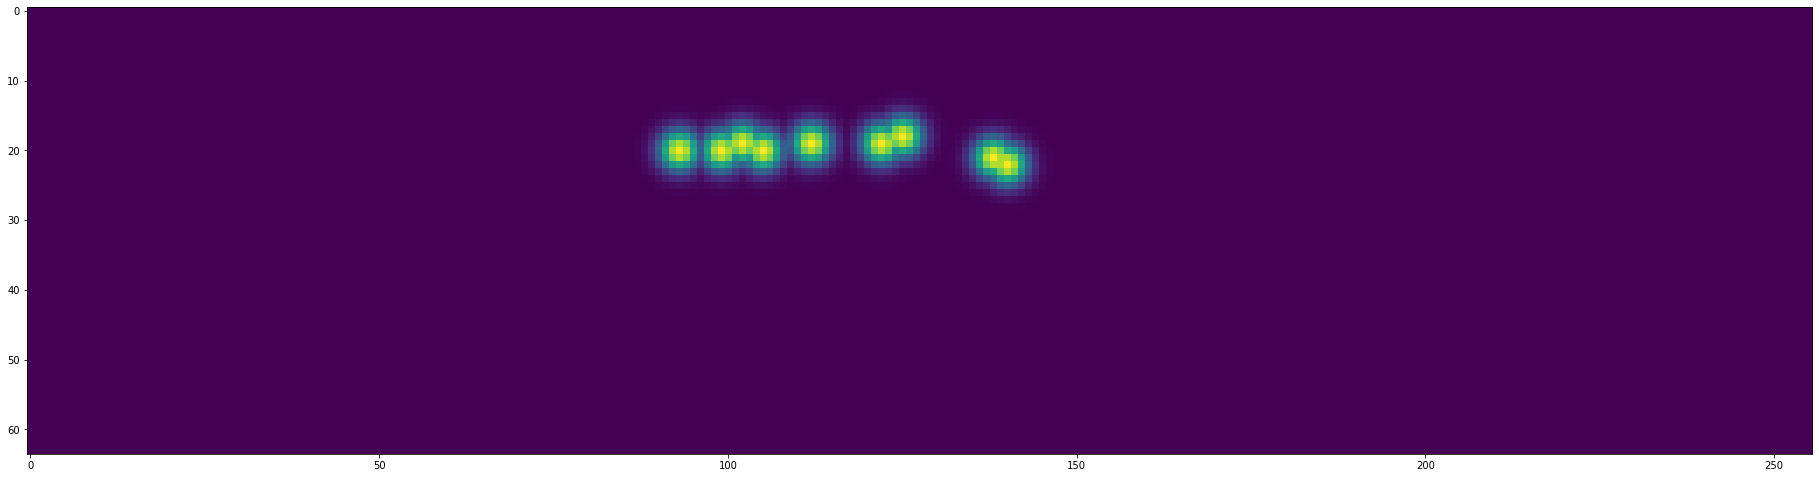

In [4]:
plt.figure(figsize=(32,32))
plt.imshow(gaussian_mask(train_dataset[2][1]))
plt.show()

# Training

In [5]:
import random

def _neg_loss(pred, gt):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    
    for i in range(gt.shape[0]):
        gt[i] = torch.from_numpy(gaussian_mask(gt[i].cpu()))
    
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

def criterion(prediction, mask, regr, weight=0.8, size_average=True):

    # Binary mask loss
    pred_mask = prediction[0]['hm']
    pred_mask = torch.sigmoid(pred_mask[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)

    #mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    #mask_loss = -mask_loss.mean(0).sum()
    
    mask_loss = _neg_loss(pred_mask,mask)
    
    # Regression L1 loss
    #pred_regr = prediction[:, 1:]
    pred_regr = prediction[0]['reg']
    #regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1
    
    #for i in range(regr.shape[0]):
    #    for j in range(regr.shape[1]):
    #        regr[i][j] = torch.from_numpy(gaussian_mask_reg(regr[i][j].cpu()))

    regr_loss = (torch.min(torch.abs(pred_regr - regr), torch.abs((pred_regr - regr)**2)).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    # smooth l1 - torch.min(torch.abs(pred_regr - regr), torch.abs((pred_regr - regr)**2))
    regr_loss = regr_loss.mean(0)

    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    #if not size_average:
    #    loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

def train(epoch, history=None):
    model.train()
    t = tqdm(train_loader)
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        
        if epoch < SWITCH_LOSS_EPOCH :
            loss, mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,1)
        else:
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5)  
        
        t.set_description(f'train_loss (l={loss:.3f})(m={mask_loss:.2f}) (r={regr_loss:.4f}')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()

    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}\tMaskLoss: {:.6f}\tRegLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data,
        mask_loss.data,
        regr_loss.data))

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            if epoch < SWITCH_LOSS_EPOCH :
                loss,mask_loss, regr_loss= criterion(output, mask_batch, regr_batch,1, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
                loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data 

    
    valid_loss /= len(dev_loader.dataset)
    valid_mask_loss /= len(dev_loader.dataset)
    valid_regr_loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()

    
    print('Dev loss: {:.4f}'.format(valid_loss))
    return valid_loss



In [ ]:
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    valid_loss = evaluate(epoch, history)
    
    model_name = 'dla34'
    torch.save(model.state_dict(), './model-'+'_'+model_name+'_' +str(epoch)+'_'+str(valid_loss)+'.pth')

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Train Epoch: 0 	LR: 0.001000	Loss: 0.523993	MaskLoss: 0.523993	RegLoss: 0.065512
Dev loss: 0.2222



Train Epoch: 1 	LR: 0.001000	Loss: 0.535228	MaskLoss: 0.535228	RegLoss: 0.059469
Dev loss: 0.1787



Train Epoch: 2 	LR: 0.001000	Loss: 0.713570	MaskLoss: 0.713570	RegLoss: 0.066142
Dev loss: 0.1520


In [ ]:
model_name = 'dla34'
torch.save(model.state_dict(), './model-'+'_'+model_name+'_'+str(valid_loss)+'.pth')

In [ ]:
history['train_loss'].iloc[100:].plot();

In [ ]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss', color = 'red');
plt.show()

In [ ]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

In [ ]:
# model.load_state_dict(torch.load( './model-dla34'+'_'+'w08'+'.pth'))
# model.eval()

# Visualize predictions

In [ ]:
for i in range(10,20):
    img, mask, regr = dev_dataset[i]

    plt.figure(figsize=(16,16))
    plt.title('Input image')
    plt.imshow(np.rollaxis(img, 0, 3))
    plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Ground truth mask')
    plt.imshow(mask)
    plt.show()

    output = model(torch.tensor(img[None]).to(device))
    logits = output[0]['hm'].data.cpu().numpy()

    plt.figure(figsize=(16,16))
    plt.title('Model predictions')
    plt.imshow(logits[0,0])
    plt.show()


    plt.figure(figsize=(16,16))
    plt.title('Model predictions thresholded')
    plt.imshow(logits[0,0] > -1)
    plt.show()

In [ ]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

# Evaluation

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
import matplotlib.pyplot as plt
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

def print_pr_curve(result_flg, scores, recall_total=1):
    average_precision = average_precision_score(result_flg, scores)
    precision, recall, _ = precision_recall_curve(result_flg, scores)
    recall *= recall_total
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

In [ ]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores


In [ ]:
threshold1 = -1
threshold2 = 1
threshold3 = 1

In [ ]:
def extract_coords(prediction, threshold1):
    
    img = prediction[0][0].cpu().numpy()
    #logits = prediction[0][0].cpu().numpy()
    logits = peak_tmp(prediction[0].cpu().numpy(), threshold1, threshold2, threshold3)
    
    regr_output = prediction[1].cpu().numpy()
    points = np.argwhere(logits > threshold1)

    # top 100 points
    (xlist, ylist) =  np.where(img>np.sort(img.reshape((1,-1)))[0][-100])
    top_list = [pair for pair in zip(list(xlist), list(ylist))]
    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    
    for r, c in points:
        if (r,c) not in top_list:
            continue
            
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def extract_coords_tmp(prediction, threshold1, threshold2, threshold3):
    
    img = prediction[0][0].cpu().numpy()
    logits = peak_tmp(prediction[0].cpu().numpy(), threshold1, threshold2, threshold3)
    #logits = prediction[0][0].cpu().numpy()
    
    regr_output = prediction[1].cpu().numpy()
    points = np.argwhere(logits > threshold1)

    # top 100 points
    (xlist, ylist) =  np.where(img>np.sort(img.reshape((1,-1)))[0][-100])
    top_list = [pair for pair in zip(list(xlist), list(ylist))]
    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    
    for r, c in points:
        if (r,c) not in top_list:
            continue
            
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def peak_tmp(array, threshold1, threshold2, threshold3):
    (xlist, ylist) = np.where(array[0]>np.sort(array[0].reshape((1,-1)))[0][-100])
    
    peak_array = array[0]
    maximum = array.max()
    threshold_iter = 0
    
    while np.sum(peak_array>threshold1)<5 and threshold_iter<8:
        threshold_iter+=1
        peak_array += 0.5
        print("brighter:", np.sum(peak_array>threshold1))
    
    advantage = np.zeros(array[0].shape)
    penalty = np.zeros(array[0].shape)
    
    for k in range(len(xlist)):
        i = xlist[k]
        j = ylist[k]
        ct1 = 0 # 주변의 점들이 top 100 안에 있는가
        ct2 = 0 # 주변의 점들의 값이 더 작은가 
        
        if 0<i<array.shape[1]-1 and 0<j<array.shape[2]-1:    
            surroundings = [(i-1,j+1),(i-1,j),(i-1,j+1),(i,j-1),(i,j+1),(i+1,j+1),(i+1,j),(i+1,j+1)]
            for xy in surroundings:
                if (xy[0], xy[1]) in list(zip(xlist, ylist)):                    
                    ct1 += 1
                if peak_array[i,j] > peak_array[xy[0], xy[1]]:
                    ct2 += 1
            if ct1 > 6 and ct2 > 7:
                advantage[i,j] += min((maximum - peak_array[i,j])*(1/2),2)
                
    
    
    
    for i in range(1,array.shape[1]-1):
        for j in range(1,array.shape[2]-1):    
            ct_sur = 0
            ct_vert = 0
            ct_hori = 0
            surroundings = [(i,j),(i,j+1),(i+1,j),(i+1,j+1)]
            horizontal = [(i,j-1),(i,j),(i,j+1)]
            vertical = [(i-1,j),(i,j),(i+1,j)] 
            
            for xy in surroundings:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_sur += 1
                    
            for xy in vertical:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_vert += 1

            for xy in vertical:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_hori += 1

            if ct_sur > 2:
                idx_small = np.array([array[0][i,j],array[0][i,j+1],array[0][i+1,j],array[0][i+1,j+1]]).argsort()[:2]
                idx_list = [[i,j],[i,j+1],[i+1,j],[i+1,j+1]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

            if ct_vert == 3:
                idx_small = np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]).argsort()[:2]
                idx_list = [[i-1,j],[i,j],[i+1,j]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

            if ct_hori == 3:
                idx_small = np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]).argsort()[:1]
                idx_list = [[i,j-1],[i,j],[i,j+1]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

    #print("advantage:", np.sum(advantage)*threshold2)
    #print("penalty:", np.sum(penalty)*threshold3)
    
    
    peak_array = peak_array = peak_array + advantage*threshold2 + penalty*threshold3
    
    return peak_array #, advantage

In [ ]:
import copy

predictions = []
dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=0)
model.eval()
for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    
    for i in range(output[0]['hm'].shape[0]):
        #coords = extract_coords((output[0]['hm'][i], output[0]['reg'][i]),-1.5)
        coords = extract_coords_tmp((output[0]['hm'][i], output[0]['reg'][i]), threshold1,threshold2,threshold3 )
        s = coords2str(coords)
        predictions.append(s)
        
df_dev['PredictionString'] = copy.copy(predictions)

valid_df = df_dev
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('../input/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    if np.sum(result_flg) > 0:
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
        print_pr_curve(result_flg, scores, recall)
    else:
        ap = 0
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)

In [ ]:
threshold1 = -1
threshold2 = 1
threshold3 = 1

In [ ]:
for i in range(40,50):
    img, mask, regr = train_dataset[i]
    plt.figure(figsize=(16,16))
    plt.title('Input image')
    plt.imshow(np.rollaxis(img, 0, 3))
    plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Ground truth mask')
    plt.imshow(mask)
    plt.show()
    
    output = model(torch.tensor(img[None]).to(device))
    output = output[0]['hm']
    logits = output[0,0].data.cpu().numpy()

    plt.figure(figsize=(16,16))
    plt.title('Model predictions')
    plt.imshow(logits)
    plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Model predictions thresholded')
    plt.imshow(logits>-1)
    plt.show()
    
    img = peak_tmp(output[0].detach().cpu().numpy(),threshold1,threshold2,threshold3)
    plt.figure(figsize=(16,16))
    plt.title('peak')
    plt.imshow(img>threshold1)
    plt.show()
    


# Make submission

In [ ]:
def show_coords(prediction, threshold1, threshold2, threshold3):
    #logits = peak(prediction[0], threshold1) 
    #logits = peak_tmp(output[0].detach().cpu().numpy(),threshold1,threshold2, threshold3)
    
    logits = prediction[0][0].cpu().numpy()
    plt.figure(figsize=(12, 8))
    plt.title('logits')
    plt.imshow(logits)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.title('logits')
    plt.imshow(logits>threshold1)
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.title('peak_tmp')
    plt.imshow(peak_tmp(output[0].detach().cpu().numpy(),threshold1, threshold2, threshold3)>threshold1)
    plt.show()
    

# Show prediction results

In [ ]:
threshold1 = -1
threshold2 = 1
threshold3 = 1
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=0)
model.eval()

for img, _, _ in tqdm(test_loader):
    
    plt.figure(figsize=(12, 8))
    plt.title('Original Image')
    plt.imshow(np.einsum('ijk->jki', img[0]))
    plt.show()
    
    with torch.no_grad():
        output = model(img.to(device))
    output = output[0]['hm']
    
    show_coords(output,threshold1, threshold2, threshold3)
        

# Submission

In [ ]:
predictions = []
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=0)
model.eval()
plot = False
for img, _, _ in tqdm(test_loader):
    idx = 0
    with torch.no_grad():
        output = model(img.to(device))
    for i in range(output[0]['hm'].shape[0]):
        #coords = extract_coords((output[0]['hm'][i], output[0]['reg'][i]),threshold1)
        coords = extract_coords_tmp((output[0]['hm'][i], output[0]['reg'][i]),threshold1, threshold2, threshold3)
        s = coords2str(coords)
        predictions.append(s)
        if plot == True:
            plt.figure(figsize=(15, 8))
            plt.imshow(np.einsum('ijk->jki', img[idx]))
            plt.show()

        idx += 1

test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('./prediction-'+model_name+'_'+str(threshold1)+'_'+str(threshold2)+'_' \
            +str(threshold3)+ '.csv', index=False)
test.head()